# Plots

Import necessary packages

In [732]:
import sqlite3
import pandas as pd

Create dataframes based on the database and relations between data and remove the duplicate columns that may exist.

In [733]:
con = sqlite3.connect("database.db")

# Player <-> Awards
pl_aw = pd.read_sql_query("SELECT * FROM awards_players INNER JOIN players ON awards_players.playerID = players.bioID", con)

# Player <-> Teams
pl_tm = pd.read_sql_query("SELECT * FROM players_teams INNER JOIN players ON players_teams.playerID = players.bioID", con)

# Teams <-> Post Season Results (aggregated)
tm_psa = pd.read_sql_query("SELECT * FROM teams_post INNER JOIN teams ON (teams_post.tmID = teams.tmID AND teams_post.year = teams.year)", con)

# Coach <-> Teams
cc_tm = pd.read_sql_query("SELECT * FROM coaches INNER JOIN teams ON (coaches.tmID = teams.tmID AND coaches.year = teams.year)", con)


pl_aw = pl_aw.loc[:,~pl_aw.columns.duplicated()]
pl_tm = pl_tm.loc[:,~pl_tm.columns.duplicated()]
tm_psa = tm_psa.loc[:,~tm_psa.columns.duplicated()]
cc_tm = cc_tm.loc[:,~cc_tm.columns.duplicated()]

In [738]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

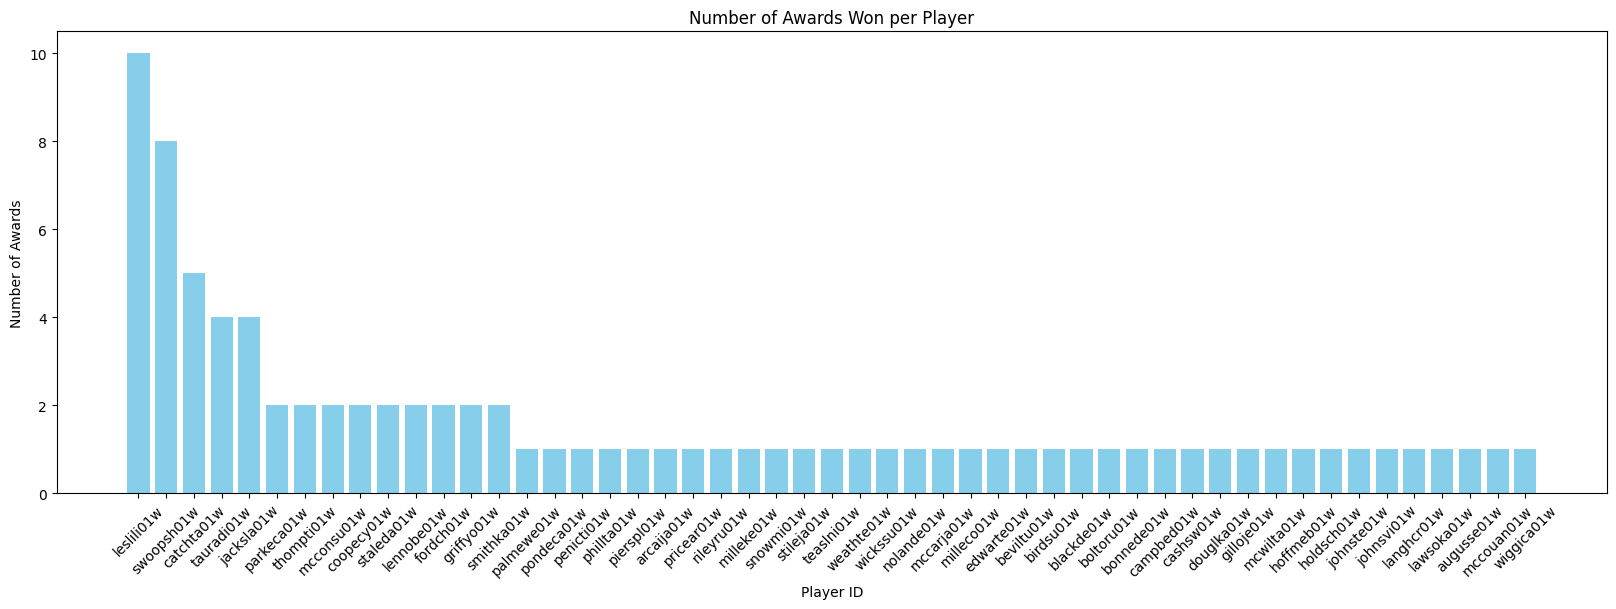

In [739]:
# Calculate the number of awards won per player
awards_count = pl_aw.groupby('playerID').size().reset_index(name='count')

# Sort by the count of awards in descending order
awards_count = awards_count.sort_values(by='count', ascending=False)

# Merge awards count with player attributes
merged_df = pd.merge(awards_count, pl_aw, on='playerID', how='inner')

# Create the plot
plt.figure(figsize=(20, 6))
plt.bar(merged_df['playerID'], merged_df['count'], color='skyblue')
plt.xlabel('Player ID')
plt.ylabel('Number of Awards')
plt.title('Number of Awards Won per Player')
plt.xticks(rotation=45)
plt.show()

In [740]:
# Plot weight and height in relation to playing position and awards won

def plot_weight_height_awards(merged_df, color_map, legend_column):
    # Scatter plots
    plt.figure(figsize=(15, 6))
    marker = 'o'

    merged_df = merged_df.sort_values(by=['weight', 'height'], ascending=[True, True])


    # Awards vs. Weight
    plt.subplot(1, 2, 1)
    for i, row in merged_df.iterrows():
        color = color_map[row[legend_column]]
        plt.scatter(row['count'], row['weight'], color=color, marker=marker, s=50, alpha=0.7)

    plt.xlabel('Number of Awards')
    plt.ylabel('Weight')
    plt.title('Awards vs. Weight')

    # Awards vs. Height
    plt.subplot(1, 2, 2)
    for i, row in merged_df.iterrows():
        color = color_map[row[legend_column]]
        plt.scatter(row['count'], row['height'], color=color, marker=marker, s=50, alpha=0.7)

    plt.xlabel('Number of Awards')
    plt.ylabel('Height')
    plt.title('Awards vs. Height')

    # Add a legend for positions
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=pos, 
                                markerfacecolor=color, markersize=10) for pos, color in color_map.items()]
    plt.legend(handles=legend_elements, title='Position', bbox_to_anchor=(1.2, 0), loc='lower right')

    plt.tight_layout()
    plt.show()

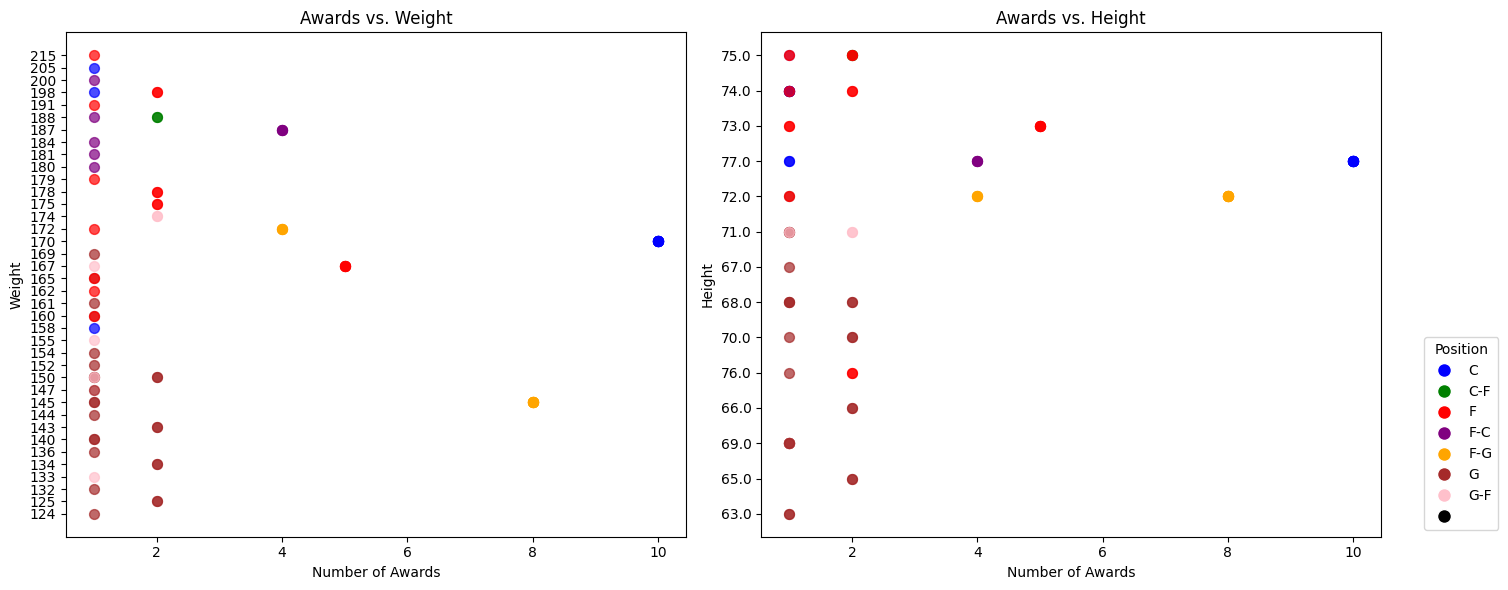

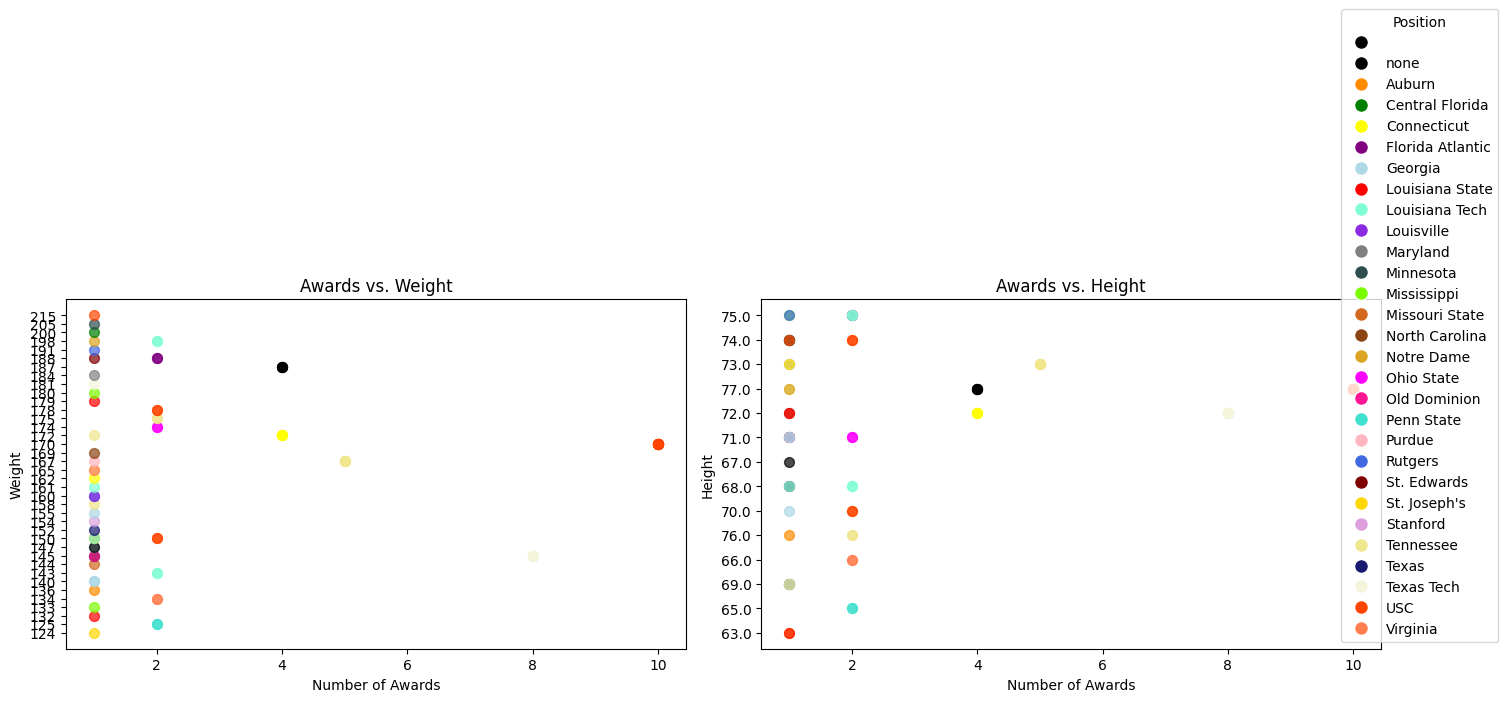

In [741]:

# Define custom color map for positions
pos_color_map = {
    'C': 'blue',
    'C-F': 'green',
    'F': 'red',
    'F-C': 'purple',
    'F-G': 'orange',
    'G': 'brown',
    'G-F': 'pink',
    '': 'black'
}

college_color_map = {
    '': 'black',
    'none': 'black',
    'Auburn': 'darkorange',
    'Central Florida': 'green',
    'Connecticut': 'yellow',
    'Florida Atlantic': 'purple',
    'Georgia':'lightblue',
    'Louisiana State': 'red',
    'Louisiana Tech': 'aquamarine',
    'Louisville': 'blueviolet',
    'Maryland': 'grey',
    'Minnesota': 'darkslategray',
    'Mississippi': 'lawngreen',
    'Missouri State': 'chocolate',
    'North Carolina': 'saddlebrown',
    'Notre Dame': 'goldenrod',
    'Ohio State': 'magenta',
    'Old Dominion': 'deeppink',
    'Penn State': 'turquoise',
    'Purdue': 'lightpink',
    'Rutgers': 'royalblue',
    'St. Edwards': 'maroon',
    "St. Joseph's": 'gold',
    'Stanford': 'plum',
    'Tennessee': 'khaki',
    'Texas': 'midnightblue',
    'Texas Tech': 'beige',
    'USC': 'orangered',
    'Virginia': 'coral'
 
}


plot_weight_height_awards(merged_df, pos_color_map, 'pos')
plot_weight_height_awards(merged_df, college_color_map, 'college')


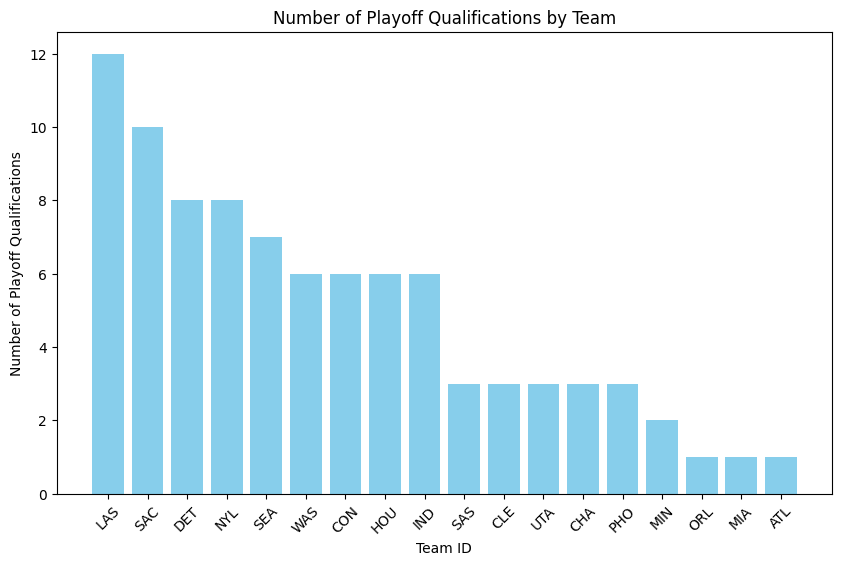

In [742]:
# Remove duplicate columns
cc_tm = cc_tm.loc[:,~cc_tm.columns.duplicated()].copy()

# Calculate the number of awards won per team
playoffs_count = cc_tm[cc_tm['playoff'] == 'Y'].groupby('tmID').size().reset_index(name='playoff_count')

playoffs_count = playoffs_count.sort_values(by='playoff_count', ascending=False)

# Merge awards count with player attributes
merged_df = pd.merge(awards_count, pl_aw, on='playerID', how='inner')

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(playoffs_count['tmID'], playoffs_count['playoff_count'], color='skyblue')
plt.xlabel('Team ID')
plt.ylabel('Number of Playoff Qualifications')
plt.title('Number of Playoff Qualifications by Team')
plt.xticks(rotation=45)
plt.show()



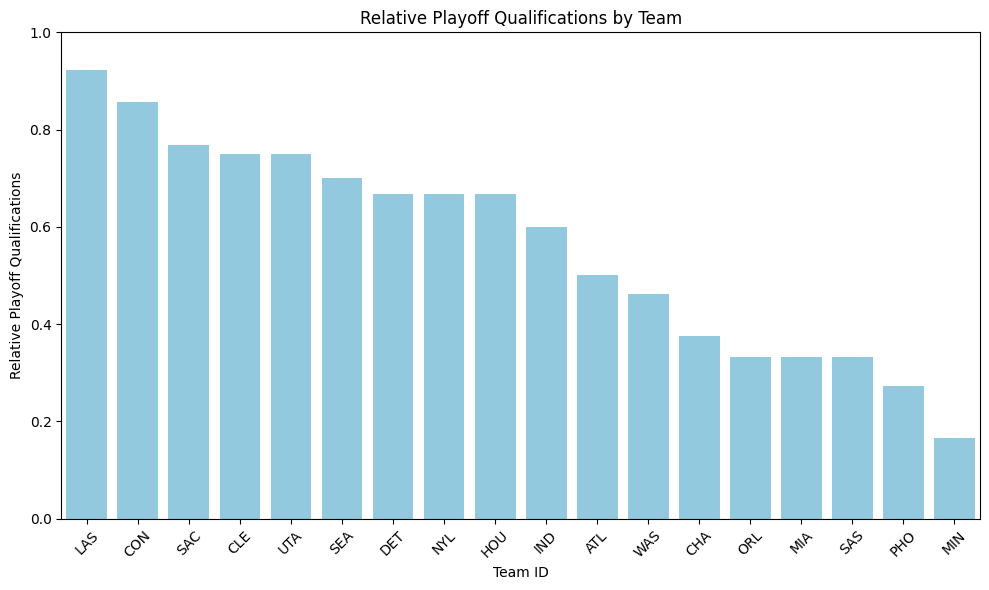

In [743]:
# Relative playoff qualifications plot

# Group by 'tmID' and calculate total attempts (Y values + N values)
total_attempts = cc_tm.groupby('tmID')['playoff'].count().reset_index(name = 'playoff_attempts')

relative_wins = pd.merge(playoffs_count, total_attempts, on='tmID', suffixes=('_playoffs', '_attempts'))

relative_wins['relative_wins'] = relative_wins['playoff_count'] / relative_wins['playoff_attempts']

relative_wins = relative_wins.sort_values(by='relative_wins', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(x='tmID', y='relative_wins', data=relative_wins, color='skyblue')
plt.xlabel('Team ID')
plt.ylabel('Relative Playoff Qualifications')
plt.title('Relative Playoff Qualifications by Team')
plt.xticks(rotation=45)
plt.ylim(0.0, 1.0)
plt.tight_layout()
plt.show()



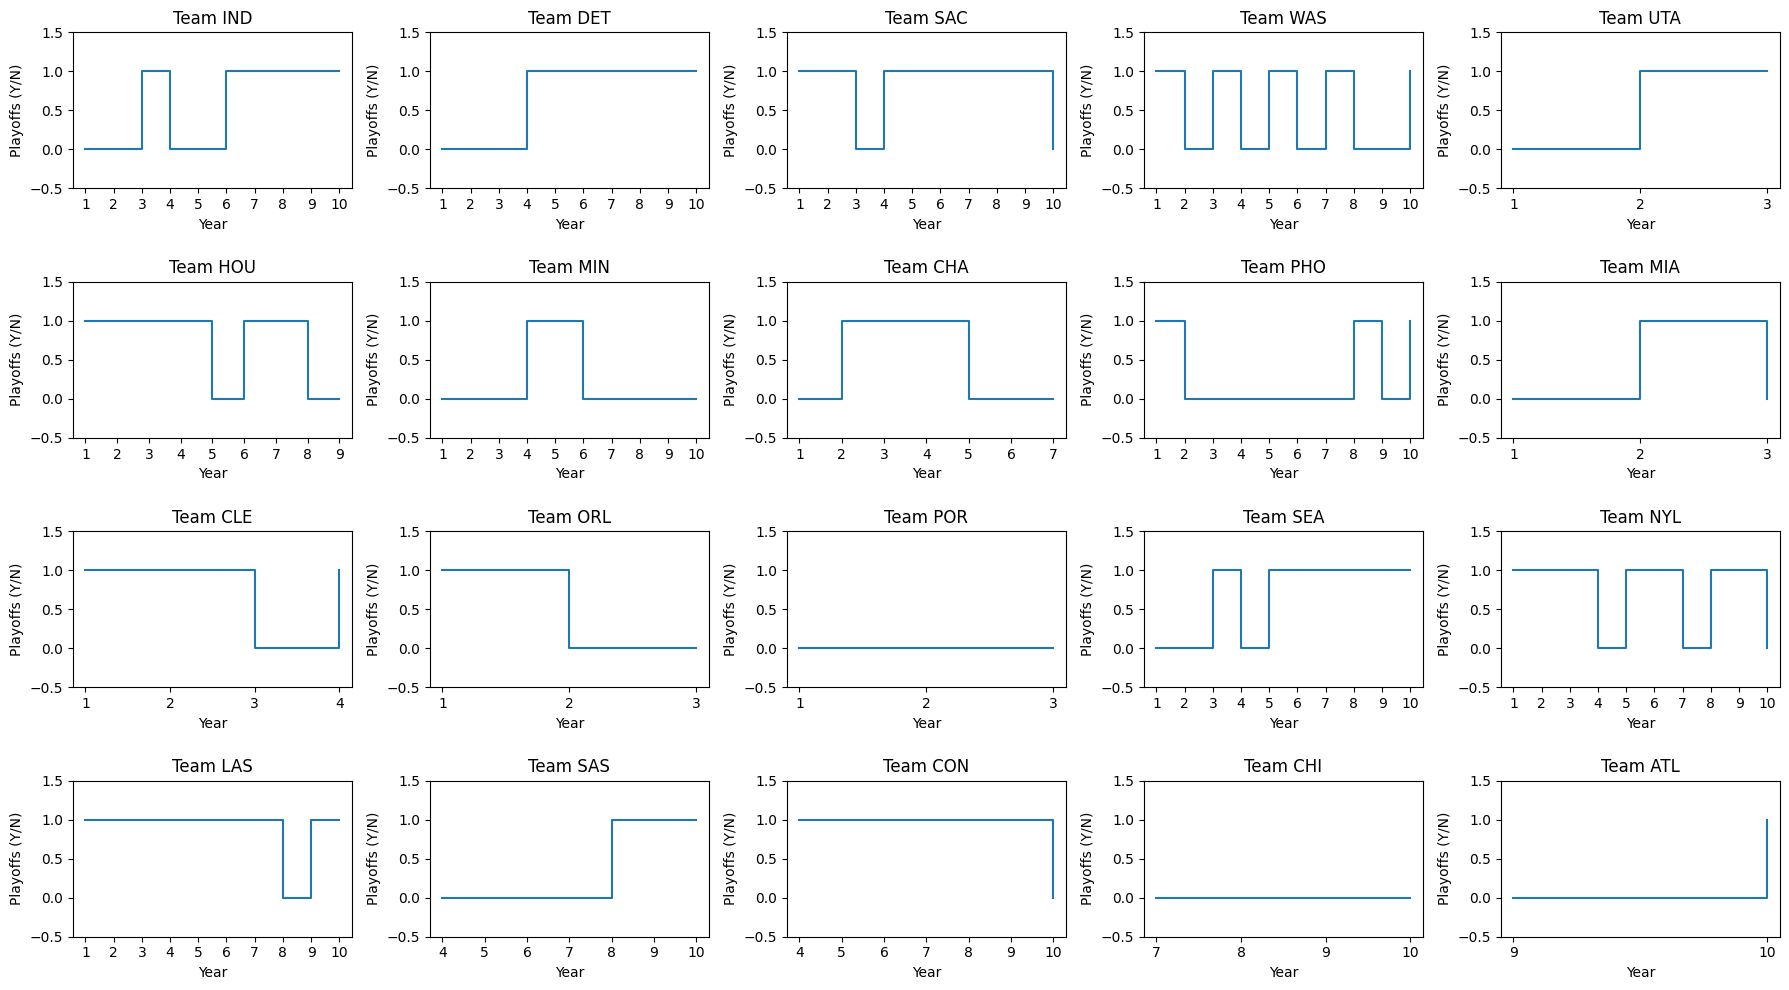

In [744]:
# Team's Playoff Qualification over the years

cc_tm['year'] = pd.to_numeric(cc_tm['year'], errors='coerce')
cc_tm['playoff'] = (cc_tm['playoff'] == 'Y').astype(int)
cc_tm.sort_values(by='year', inplace=True)

unique_teams = cc_tm['tmID'].unique()

num_teams = len(unique_teams)
num_rows = 4
num_cols = (num_teams + 1) // num_rows


plt.figure(figsize=(18, 10))
for i, team in enumerate(unique_teams, 1):
    plt.subplot(num_rows, num_cols, i)
    team_data = cc_tm[cc_tm['tmID'] == team]
    plt.step(team_data['year'], team_data['playoff'], where='post')  # Use step function
    plt.xlabel('Year')
    plt.ylabel('Playoffs (Y/N)')
    plt.title(f'Team {team}')
    plt.ylim(-0.5, 1.5)
    plt.xticks(list(range(int(team_data['year'].min()), int(team_data['year'].max())+1)))  # Set xticks to integers


plt.tight_layout(h_pad=2)
plt.show()


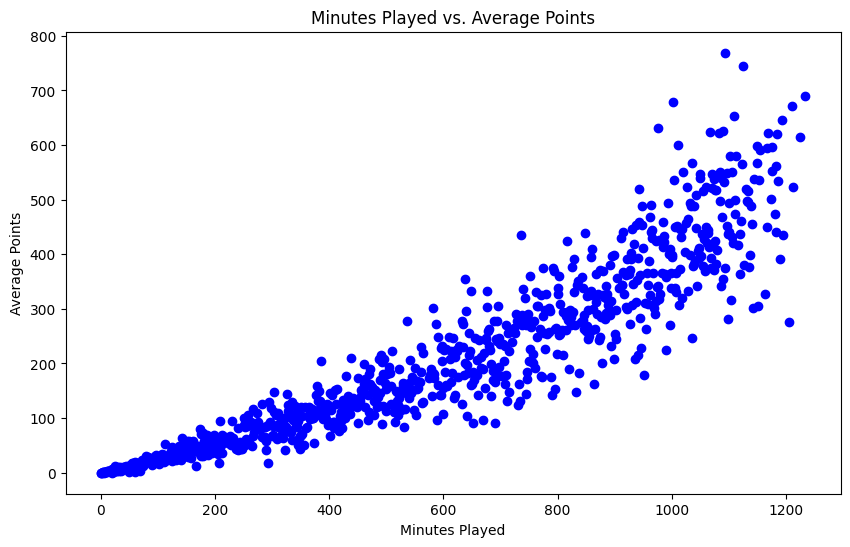

In [753]:
# Relation between players played minutes and points

grouped_data = pl_tm.groupby('minutes')['points'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.scatter(grouped_data['minutes'], grouped_data['points'], color='blue')
plt.xlabel('Minutes Played')
plt.ylabel('Average Points')
plt.title('Minutes Played vs. Average Points')

plt.show()


### Outliers

Now, to analyse the `weight` and `height` attributes' Z-Score and IQR.

In [746]:
import matplotlib.pyplot as plt
import scipy.stats as stats

Height Z-Score
 0     0.462795
1     1.315661
2     1.315661
3    -0.105782
4    -0.105782
        ...   
90   -0.958648
91    0.462795
92   -0.390070
93   -0.105782
94   -1.242936
Name: height, Length: 86, dtype: float64

Weight Z-Score
 0     0.731387
1     0.326565
2     0.326565
3     0.275962
4    -0.938505
        ...   
90   -0.685491
91    0.427770
92   -0.938505
93    0.427770
94   -0.128861
Name: weight, Length: 86, dtype: float64


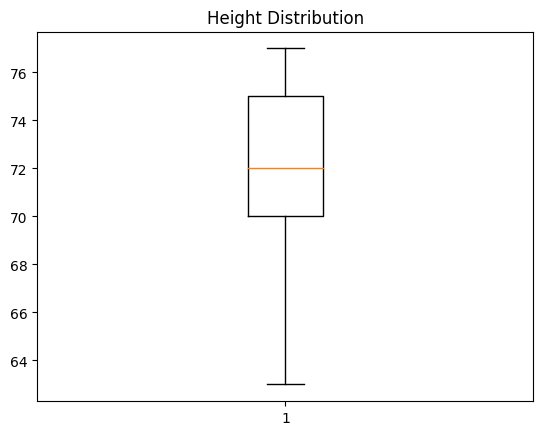

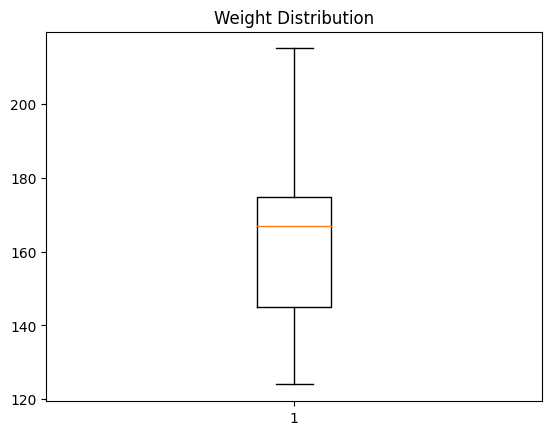

In [747]:
# Outliers for Player's Weight + Height

# Convert Height and Weight Columns into numeric values
pl_aw['height'] = pd.to_numeric(pl_aw['height'], errors='coerce')
pl_aw['weight'] = pd.to_numeric(pl_aw['weight'], errors='coerce')

pl_tm['height'] = pd.to_numeric(pl_tm['height'], errors='coerce')
pl_tm['weight'] = pd.to_numeric(pl_tm['weight'], errors='coerce')

pl_aw = pl_aw.dropna(subset=['height', 'weight'])
pl_tm = pl_tm.dropna(subset=['height', 'weight'])

height_zscores = stats.zscore(pl_aw['height'])
weight_zscores = stats.zscore(pl_aw['weight'])

# Plot boxplot
print("Height Z-Score\n", height_zscores)
print("\nWeight Z-Score\n", weight_zscores)

plt.title('Height Distribution')
plt.boxplot(pl_aw['height'])
plt.show()

plt.title('Weight Distribution')
plt.boxplot(pl_aw['weight'])
plt.show()

Team Played minutes Z-Score
 0    -1.387722
1    -1.261994
2    -1.261994
3    -1.764905
4    -1.639177
        ...   
75    1.001108
76    0.749653
77    1.378292
78    0.875380
79    0.623925
Name: min, Length: 80, dtype: float64


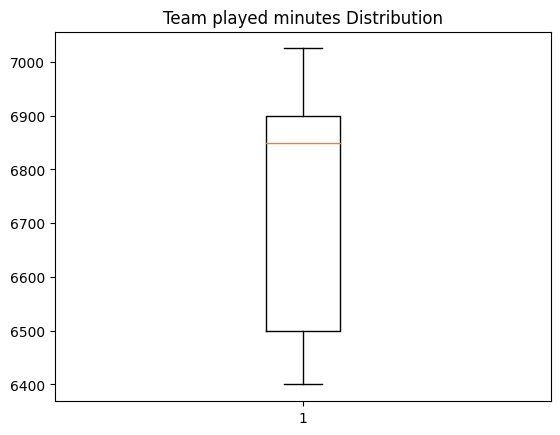

In [748]:
# Outlier for Team's played minutes

tm_psa['min'] = pd.to_numeric(tm_psa['min'], errors='coerce')
cc_tm['min'] = pd.to_numeric(cc_tm['min'], errors='coerce')

tm_psa = tm_psa.dropna(subset=['min'])
cc_tm = cc_tm.dropna(subset=['min'])


print("Team Played minutes Z-Score\n", stats.zscore(tm_psa['min']))
plt.title('Team played minutes Distribution')
plt.boxplot(tm_psa['min'])
plt.show()

Player Played minutes Z-Score
 0       0.958997
1       0.844940
2       0.808776
3      -0.109242
4       0.767048
          ...   
1871   -1.291537
1872   -0.245554
1873    0.836594
1874   -1.311010
1875   -1.311010
Name: minutes, Length: 1876, dtype: float64


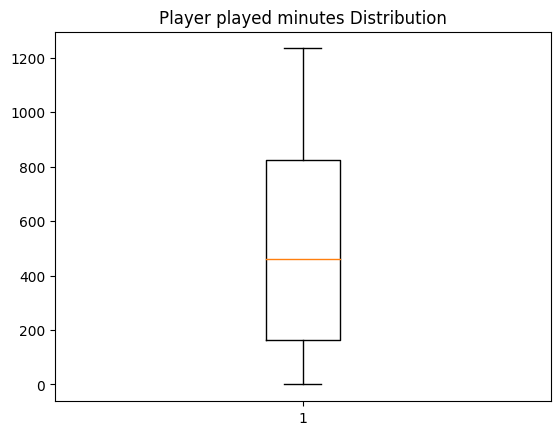

In [749]:
# Outlier for Player's played minutes

pl_tm['minutes'] = pd.to_numeric(pl_tm['minutes'], errors='coerce')

print("Player Played minutes Z-Score\n", stats.zscore(pl_tm['minutes']))
plt.title('Player played minutes Distribution')
plt.boxplot(pl_tm['minutes'])
plt.show()

Team's Offense Score Z-Score
 0     0.273442
1    -0.913695
2    -1.015958
3    -1.055974
4    -1.180468
        ...   
75    0.895910
76    3.301308
77    0.580230
78    0.531322
79    0.762524
Name: o_pts, Length: 80, dtype: float64


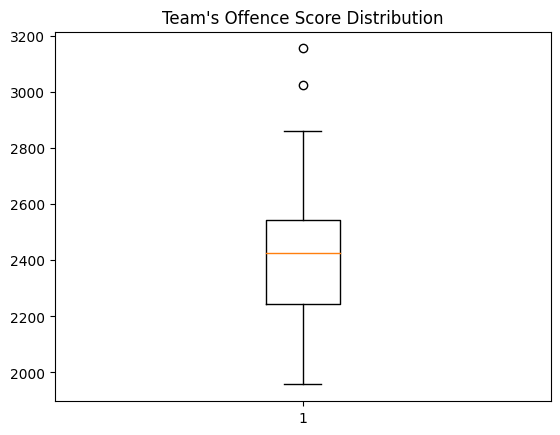

Team's Defense Score Z-Score
 0    -1.182075
1    -0.441685
2    -0.933801
3    -0.494887
4    -1.319513
        ...   
75    1.455843
76    3.096229
77    0.635650
78    0.733186
79    1.282937
Name: d_pts, Length: 80, dtype: float64


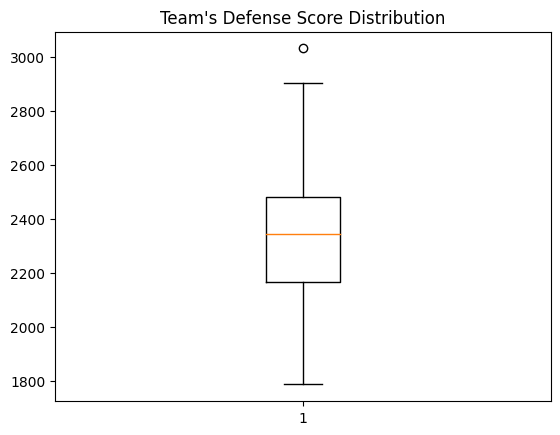

In [750]:
# Outlier Team points

tm_psa['o_pts'] = pd.to_numeric(tm_psa['o_pts'], errors='coerce')

print("Team's Offense Score Z-Score\n", stats.zscore(tm_psa['o_pts']))
plt.title("Team's Offence Score Distribution")
plt.boxplot(tm_psa['o_pts'])
plt.show()

tm_psa['d_pts'] = pd.to_numeric(tm_psa['d_pts'], errors='coerce')

print("Team's Defense Score Z-Score\n", stats.zscore(tm_psa['d_pts']))
plt.title("Team's Defense Score Distribution")
plt.boxplot(tm_psa['d_pts'])
plt.show()

Player's Scores Z-Score
 0       1.029626
1       0.850548
2       0.875248
3      -0.186869
4       0.788797
          ...   
1871   -1.051383
1872   -0.532675
1873    1.418657
1874   -1.020508
1875   -1.026683
Name: points, Length: 1876, dtype: float64


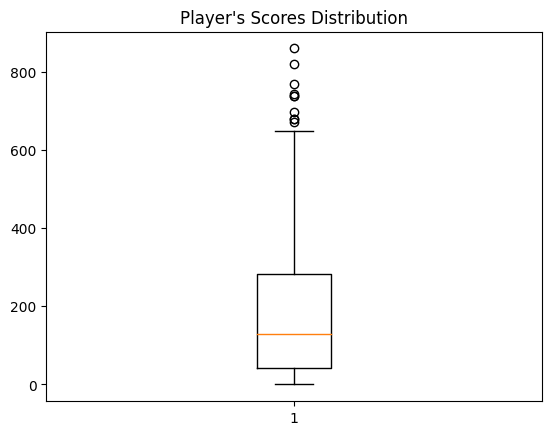

In [751]:
# Outlier Player points

pl_tm['points'] = pd.to_numeric(pl_tm['points'], errors='coerce')

print("Player's Scores Z-Score\n", stats.zscore(pl_tm['points']))
plt.title("Player's Scores Distribution")
plt.boxplot(pl_tm['points'])
plt.show()

In [752]:
# TODO: Feature engineering, number of awards per player/coach, number of awards per team
# TODO: Meter os graficos das college direitos
# TODO: Graficos Z-Score